In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

In [3]:
with open("res.pkl", "rb") as f:
    res = pickle.load(f)

In [4]:
res[0].keys()

dict_keys(['img', 'features'])

In [5]:
def parse_metadata(names):
    pref, _ = names.split(".")
    artist, version, orig, presence = pref.split("-")
    return orig, [int(x) for x in presence]

In [6]:
imgs = np.stack([x["features"] for x in res])
metadata = [parse_metadata(x["img"]) for x in res]

In [7]:
side_images = ["106", "1041", "1195", "1237"]

In [8]:
uniq_names = set(name for name, _ in metadata)
group_by_name = { n: np.array([i for i, (name, _) in enumerate(metadata) if name == n]) for n in uniq_names }
len(group_by_name)
group_by_size = { n: np.array([i for i, (_, fea) in enumerate(metadata) if sum(fea) == n]) for n in range(7) }
group_by_direction = { n: np.array([i for i, (name, _) in enumerate(metadata) if (name in side_images) == n]) for n in [True, False] }

In [9]:
tsne = TSNE(n_components=2, learning_rate='auto')
imgs_lowdim = tsne.fit_transform(imgs)

/home/spdskatr/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


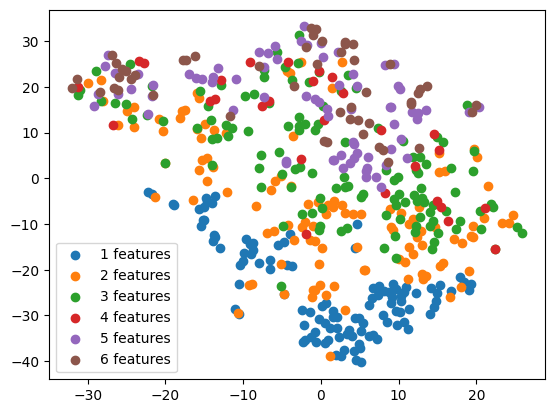

In [10]:
fig = plt.figure()
ax = fig.add_subplot()

for n, grp in group_by_size.items():
    if len(grp) > 0:
        subgrp = imgs_lowdim[grp].T
        ax.scatter(subgrp[0], subgrp[1], label=f"{n} features")

ax.legend()

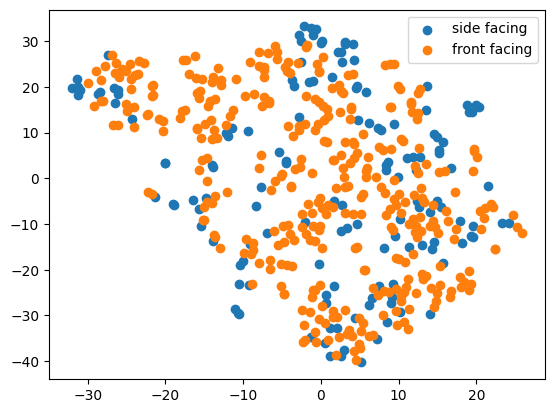

In [11]:
fig = plt.figure()
ax = fig.add_subplot()

for n, grp in group_by_direction.items():
    if len(grp) > 0:
        subgrp = imgs_lowdim[grp].T
        ax.scatter(subgrp[0], subgrp[1], label="side facing" if n else "front facing")

ax.legend()

In [12]:
num_fea = [sum(fea) for _, fea in metadata]

In [15]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(imgs, num_fea, test_size=0.3)

lr = LogisticRegression()
lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)
train_accuracy = (lr.predict(X_train) == Y_train).mean()
accuracy = (Y_pred == Y_test).mean()

/home/spdskatr/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 0.9914772727272727 Test accuracy: 0.6381578947368421


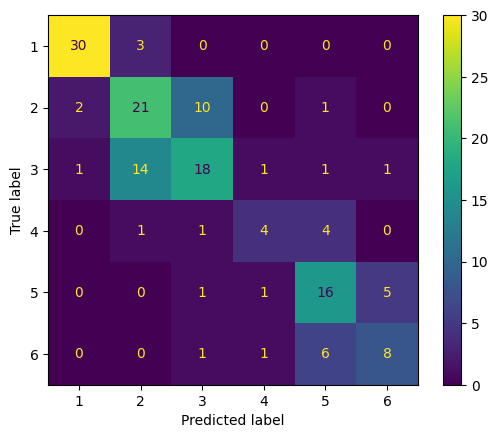

In [16]:
print(f"Train accuracy: {train_accuracy} Test accuracy: {accuracy}")
disp = sklearn.metrics.ConfusionMatrixDisplay.from_estimator(lr, X_test, Y_test)